In [86]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.misc import derivative
import time

In [87]:
data= pd.read_csv("Chwirut1_Data.txt",names=['y','x'], sep=" ")

data

,y,x
NaN,92.90,0.500
NaN,78.70,0.625
NaN,64.20,0.750
NaN,64.90,0.875
NaN,57.10,1.000
...,...,...
NaN,61.60,0.750
NaN,29.80,1.750
NaN,29.81,1.750
NaN,17.17,2.750


In [88]:
y = torch.from_numpy(data['y'].to_numpy(np.float64))
x = torch.from_numpy(data['x'].to_numpy(np.float64))

b = torch.tensor([0.1,0.01,0.02],requires_grad=True)
# b = torch.tensor([0.15,0.008,0.01],requires_grad=True)

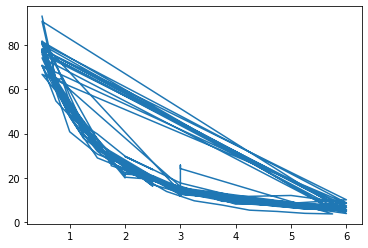

In [89]:
plt.plot(x.numpy(),y.numpy())

In [90]:
## Numerical Differentiation

b = np.array([0.1,0.01,0.02]).reshape(-1,1)

x=x.detach().numpy()

u=0.1 #beta multiply identity matrix
beta = 10
V_prev = 0


def f0(b0):
    return  np.exp(-b0*x) / (b[1]+b[2]*x)-y.detach().numpy()  
def f1(b1):
    return  np.exp(-b[0]*x) / (b1+b[2]*x)-y.detach().numpy()   
def f2(b2):
    return np.exp(-b[0]*x) / (b[1]+b2*x)-y.detach().numpy() 

start_time = time.perf_counter()   
    
for c in range(200):

    y_pred = np.exp((-b[0]*x)) / (b[1]+b[2]*x) 
    error = (y_pred - y.detach().numpy()).reshape(-1,1)
    
    d_b0 = derivative(f0,b[0] , dx=1e-6)
    d_b1 = derivative(f1,b[1] , dx=1e-6)
    d_b2 = derivative(f2,b[2] , dx=1e-6)
    
     
    jacobian = np.transpose(np.array([d_b0,d_b1,d_b2]))
    dParam = np.matmul(np.matmul(np.linalg.inv((np.matmul(np.transpose(jacobian),jacobian)+u*np.identity(len(b)))),np.transpose(jacobian)),error)
    b -= dParam
    V = np.sum(np.square(error))
    if(V > V_prev):
            u *= beta
    else:
            u /= beta
    V_prev = V
    print("c: ",c," error: ",V," B:", b)
    
    if V < 2.3844771393E+03:
        break
print("time taken to execute: ",time.perf_counter()-start_time)  
print("SD error is", np.std(np.square(error)))

c:  0  error:  47929.23629412158  B: [[0.21641041]
 [0.00321921]
 [0.00407729]]
c:  1  error:  425000.2163559593  B: [[0.2026534 ]
 [0.00477571]
 [0.00663797]]
c:  2  error:  56495.91590796286  B: [[0.1921797 ]
 [0.00586494]
 [0.00916638]]
c:  3  error:  5412.9897976694865  B: [[0.18985667]
 [0.00614253]
 [0.01036623]]
c:  4  error:  2402.651774608175  B: [[0.19098743]
 [0.0061629 ]
 [0.01047685]]
c:  5  error:  2379.6535191905277  B: [[0.19126877]
 [0.00616687]
 [0.01046809]]
time taken to execute:  0.006522800000084317
SD error is 26.33018005868139


In [91]:
def Jacobian(loss,params,numParams):
    
    jacobian = torch.empty(len(loss), numParams) 
    
    for i in range(len(loss)):
        
        loss[i].backward(retain_graph=True)
        
        for n in range(numParams):
            jacobian[i][n] = params.grad[n]
        params.grad.zero_()      
    return jacobian    

In [92]:
## Automatic Differentiation
num_param = len(b)
u=0.1 #beta multiply identity matrix
beta = 10
error_prev = 0
start_time = time.perf_counter()
for c in range(200):

    y_pred = torch.exp(-b[0]*x) / (b[1]+b[2]*x)

    loss = y_pred-y
    error = torch.sum(torch.square(loss)) #residual sum of squares
    print("",c," error is: ",error.detach().numpy()," b is ", b.detach().numpy())
    jacobian = Jacobian(loss,b,len(b))

    dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian)+u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),loss.float())
    with torch.no_grad():
        b -=dParam
    
        if(error > error_prev):
            u *= beta
        else:
            u /= beta
        error_prev = error
    if error< 2.3844771393E+03:#7.88539786689E+02:  given residual sum of squares
        break
print("time taken to execute: ",time.perf_counter()-start_time) 
print("SD error is", np.std(np.square(loss.detach().numpy())))

TypeError: exp(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
plt.plot(y_pred.detach(),'g', y,'r')